<a href="https://colab.research.google.com/github/rusonariga/young-modulus-calculator/blob/main/Young_modulus_calculator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Young module calculation

This notebook will be used to calculate the Young module from different samples meassured in laboratory.

$$\sigma = E \Delta l$$

where $\sigma = F/A$

In [ ]:
# Import libraries
from google.colab import files
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from scipy.stats import linregress
from scipy.stats import describe
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')

## Create general folders

In [ ]:
# Required folder setting
!pwd
if os.path.exists('data'):
  if os.path.exists('results'):
    if os.path.exists('figures'):
      print("Set up ready to upload files")
    else:
      !mkdir figures
  else:
    !mkdir results figures
else:
  !mkdir data results figures

/content
Set up ready to upload files


## Upload dataset

In [ ]:
# Upload files
%cd data
files.upload()
%cd ..
!pwd

/content/data


/content
/content


## Function to read test datasets

In [ ]:
def ReadFile(filename, folder="/content/data/"):

  data = pd.read_csv(folder+filename,delim_whitespace=True,header=None)
  # modify following definition depending the input dataset
  data.columns = ["EXTENSION [mm]", "TIME [s]", "LOAD [kgf]", "CALIBRATED WIDTH [mm]", 
                "CALIBRATED HEIGHT [mm]","CALIBRATED LENGTH [mm]"]

  # We extract data
  width = data["CALIBRATED WIDTH [mm]"][0]      # In mm
  height = data["CALIBRATED HEIGHT [mm]"][0]    # In mm
  l0 = data["CALIBRATED LENGTH [mm]"][0]        # in mm

  # We extract the length and load, last 2 values are discarded 
  l = data["EXTENSION [mm]"].to_numpy()[:-2]             # stroke displacement In mm
  F = data["LOAD [kgf]"].to_numpy()[:-2]                  # applied load In kgf

  # We convert from these units to SI units
  mm2m = 1e-3
  kgf2N = 9.81
  Pa2MPa = 1e-6
  MPa2GPa = 1e-3 

  # gage geometry conversion
  width = width*mm2m
  height = height*mm2m
  l0 = l0*mm2m 

  # test measurements conversion
  l = l*mm2m              # l in m
  F = F*kgf2N             # F in N
  
  # We compute sigma
  stress = F/(width*height)

  # We conver stress to MPa
  stress = stress*Pa2MPa

  # strain calculation
  strain = l/l0

  return l, F, width, height, l0, strain, stress

## Function to calculate Young Modulus

In [ ]:
def Young(strain, stress, thresh=0.999, stress_prop_lim_upp=50, stress_prop_lim_low=30, 
          c_t = 82.5, l_upper = 5, l_lower=5):
  
  '''Young function args:
  ( strain (from dataset), 
    stress (from dataset),
    thresh (user input to define the precision of the linear correlation apporach),
    stress_prop_lim_upp (user input of upper limit of expected proportional stress based on % of ultimate stress), 
    stress_prop_lim_low (user input of lower limit of expected proportional stress based on % of ultimate stress),
    c_t (user input of target linear zone analysis as % of porportional stress), 
    l_upper (user input upper bound of c_t in %), 
    l_lower (user input lower bound of c_t in %))
  )'''

  MPa2GPa = 1e-3 

  # Based on proportional stress limits proposed, valid zones of data are reduced
  stress_max = stress.max()
  strain_stress_max = np.mean(strain[stress == stress_max])

  stress_prop_low = stress_max * stress_prop_lim_low/100
  strain_stress_prop_low = np.min(strain[stress>stress_prop_low])

  stress_prop_upp = stress_max * stress_prop_lim_upp/100
  strain_stress_prop_upp = np.min(strain[stress>stress_prop_upp])

  # Compute linear correlation coefficient
  corr = []
  for N in range(0,strain.size):
      corr.append(np.corrcoef(strain[0:N],stress[0:N])[0,1])

  corr = np.array(corr)

  valid = corr >= thresh              #assigns all the corr values greater than thresh

  strain_corr = strain[valid]        # kept extension values that fits selected thresh 
  stress_corr = stress[valid]        # kept tension values that fits selected thresh 


  # We select stress values within the limits
  stress_valid = stress_corr[(stress_corr <= stress_prop_upp) &
                              (stress_corr >= stress_prop_low)] 

  # We select strain values within the limits
  strain_valid = strain_corr[(stress_corr <= stress_prop_upp) &
                              (stress_corr >= stress_prop_low)] 


  # we extract the desired values
  stress_yield0 = np.max(stress_valid)                        # yield stress based on the thresh values

  strain_stress_yield0 = np.max(strain_valid)                 # strain of yield stress based on the thresh values

  strain_t = strain_stress_yield0 * (c_t/100)                 # extension related to the calculated target stress

  strain_t_u = strain_stress_yield0*(c_t/100 + l_upper/100)   # upper extension value related to target stress
  strain_t_l = strain_stress_yield0*(c_t/100 - l_lower/100)   # lower extension value related to target stress

  s_t = np.interp(strain_t, strain_valid, stress_valid)       # target stresses
  s_ltu = np.interp(strain_t_u, strain_valid, stress_valid)  
  s_ltl = np.interp(strain_t_l, strain_valid, stress_valid)

  # valid values after user input
  select = [(strain_valid > strain_t_l) * (strain_valid < strain_t_u)][0]

  # linear regression to find slope
  fit = linregress(strain_valid[select], stress_valid[select])  

  # We find the crossing point for the x axis of the new linear equation
  E_zero = -fit[1]/fit[0]

  # Values of new linear equation to plot
  Eplot = np.array([E_zero, strain_stress_yield0])

  # We redefine the distance from the 0' found above
  x_ltu = strain_t_u - E_zero  # plastic_l = strain[strain>strain_stress_yield0]
  x_ltl = strain_t_l - E_zero

  # ******  We compute E  ********************
  E = (s_ltu - s_ltl)/(x_ltu- x_ltl) * MPa2GPa

  plastic_l = np.copy(strain[strain>=strain_stress_yield0])+fit[1]/fit[0]
  plastic_s = np.copy(stress[strain>=strain_stress_yield0])
  elastic_l = np.array([0, plastic_l.min()])
  elastic_s = fit[0]*elastic_l 

  strain_tmp = np.concatenate((elastic_l, plastic_l))
  stress_tmp = np.concatenate((elastic_s, plastic_s))

  dif = stress_tmp - (fit[0]*strain_tmp- 0.002*fit[0])
  Imin = []
  for i in range(len(dif)-2):
    if dif[i]*dif[i+1] < 0:
      Imin.append(i)
  val = np.min(Imin)

  # ******  We compute Sigma_y  ********************
  strain_stress_yield = strain_tmp[val]
  stress_yield = fit[0]*strain_stress_yield- 0.002*fit[0]      

  # print(f"Sigma yield = {stress_yield:0.4f} [MPa] E = {E:0.4f} [GPa]") 

  # # ******  We compute Sigma_max  ********************  
  stress_max = np.max(stress_tmp)
  strain_stress_max = np.max(strain_tmp[stress_tmp == stress_max])

  return E, stress_yield, strain_stress_yield, stress_max, strain_stress_max, strain_tmp, stress_tmp, fit

## Save results to data frame function

In [ ]:
def ToDataFrame(stress, strain, l, F, width, height, l0, E, strain_stress_yield, stress_yield, stress_max, filename=None, folder="/content/results/"):
  # Create dataframe of results
  results_columns=["EXTENSION [m]","LOAD [kgf]","STRESS [MPa]","STRAIN","CALIBRATED WIDTH [mm]",
                  "CALIBRATED HEIGHT [mm]","CALIBRATED LENGTH [mm]","E [GPa]","YIELD STRAIN",
                  "YIELD STRESS [MPa]","ULTIMATE STRESS [MPa]"]
  results = pd.DataFrame(np.nan, index = np.arange(len(l)), columns=results_columns)

  s = pd.Series(stress)
  s1 = pd.Series(s, index=results.index)
  st = pd.Series(strain)
  st1 = pd.Series(st, index=results.index)

  results["EXTENSION [m]"] = l
  results["LOAD [kgf]"] = F
  results["STRESS [MPa]"] = s1
  results["STRAIN"] = st1
  results["CALIBRATED WIDTH [mm]"][0] = width
  results["CALIBRATED HEIGHT [mm]"][0] = height 
  results["CALIBRATED LENGTH [mm]"][0] = l0
  results["E [GPa]"][0] = E
  results["YIELD STRAIN"][0] = strain_stress_yield
  results["YIELD STRESS [MPa]"][0] = stress_yield
  results["ULTIMATE STRESS [MPa]"][0] = stress_max

  # Saving results into CSV
  %cd results
  if filename != None:
    results.to_csv(folder+filename+".csv")
  %cd ..

  return results

# Sensibility analysis

Execute following cells up to MAIN in order to determinate the desired upper value of porportionality stress $\sigma_p$.

## Sensibility Main

In [ ]:
# **************  MAIN BODY ************************

E_dict = {}     #dictionary to save comparisson results

# Call function to read files and retrieve data
for file in tqdm(os.listdir("/content/data")):
  
  # calling the function to read datasets and retrieve stresses and strains
  l, F, width, height, l0, strain, stress = ReadFile(file)           
 
  
  # $$$$$$$$$$$$$$$$$$  VARIABLES TO TEST   $$$$$$$$$$$$$$$$$$$$$$$$$$$
  
  # Upper value range of proportionality stress (% of Max stress)
  max = 50
  min = 40
  points = 100      #number of evaluating points

  # Threshold value for correlation factor
  thresh=0.99
  # $$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$

  stress_prop_range = np.linspace(min,max,points) #set upper value range of proportionality stress
  
  E_tmp = []

  for stress_prop in stress_prop_range:
    E, stress_yield, strain_stress_yield, stress_max, strain_stress_max, strain_final, stress_final, fit= Young(strain, stress, thresh, stress_prop_lim_upp=stress_prop)
    E_tmp.append(E)

  
  E_dict[file] = E_tmp

## Sensibility figures

### E <i>vs</i> Upper stress proportional limit value

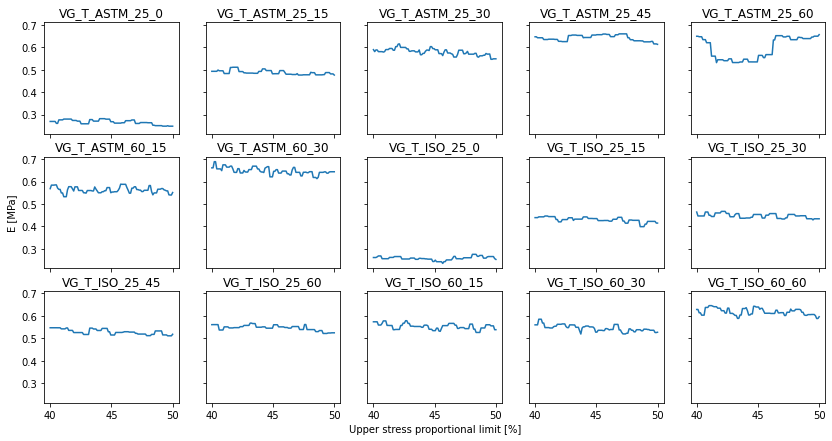

In [ ]:
fig, ax = plt.subplots(figsize=(14,7),nrows=3, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()

i = 0
for label in sorted(list(E_dict)):
  ax[i].plot(stress_prop_range, E_dict[label], label=label)
  ax[i].set_title(label)
  i += 1

ax[-3].set_xlabel("Upper stress proportional limit [%]")
ax[5].set_ylabel("E [MPa]")
plt.show()

### Nomarlized E ($E/E_{max}$) <i>vs</i> Upper stress proportional limit value

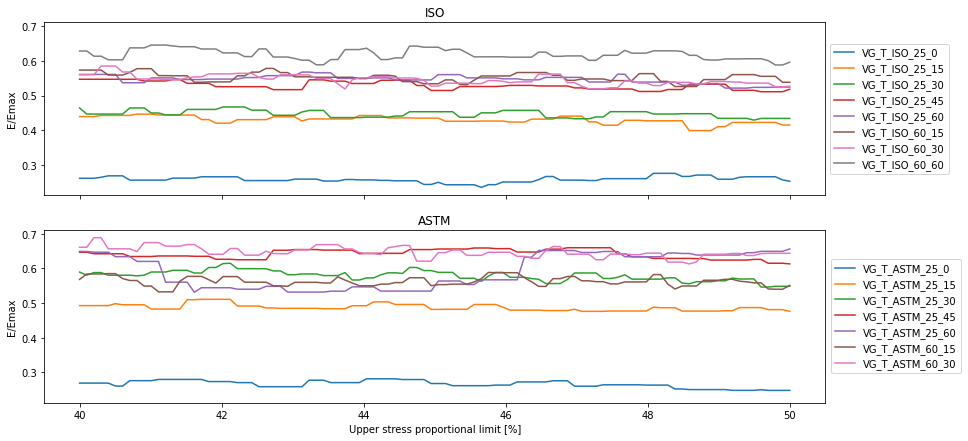

In [ ]:
fig, ax = plt.subplots(figsize=(14,7),nrows=2, ncols=1, sharex=True, sharey=True)
ax = ax.flatten()

i = 0
for label in sorted(list(E_dict)):
  if "ISO" in label:
    i = 0
  elif "ASTM" in label:
    i = 1
  ax[i].plot(stress_prop_range, E_dict[label], label=label)
  
ax[0].set_title("ISO")
ax[1].set_title("ASTM")
ax[0].legend(loc='center right',bbox_to_anchor=(1.165,0.5))
ax[1].legend(loc='center right',bbox_to_anchor=(1.18,0.5))

ax[1].set_xlabel("Upper stress proportional limit [%]")
ax[0].set_ylabel("E/Emax")
ax[1].set_ylabel("E/Emax")
plt.show()

### E distribution histogram

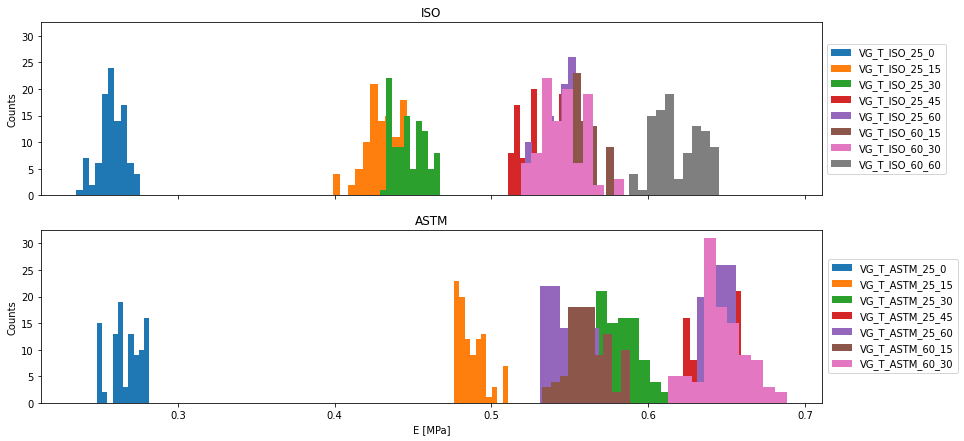

In [ ]:
fig, ax = plt.subplots(figsize=(14,7),nrows=2, ncols=1, sharex=True, sharey=True)
ax = ax.flatten()

i = 0
for label in sorted(list(E_dict)):
  if "ISO" in label:
    i = 0
  elif "ASTM" in label:
    i = 1
  ax[i].hist(E_dict[label], label=label)
  
ax[0].set_title("ISO")
ax[1].set_title("ASTM")
ax[0].legend(loc='center right',bbox_to_anchor=(1.165,0.5))
ax[1].legend(loc='center right',bbox_to_anchor=(1.18,0.5))

ax[1].set_xlabel("E [MPa]")
ax[0].set_ylabel("Counts")
ax[1].set_ylabel("Counts")
plt.show()

In [ ]:
ISO_df = pd.DataFrame(columns=["Name", "Mean", "Sigma", "Relative"])
ASTM_df = pd.DataFrame(columns=["Name", "Mean", "Sigma", "Relative"])
for label in sorted(list(E_dict)):
  desc = describe(E_dict[label])

  s = pd.Series({"Name":label, "Mean":desc.mean, "Sigma":np.sqrt(desc.variance), "Relative":np.round(np.sqrt(desc.variance)/desc.mean*100,1)})
  
  if "ISO" in label:
    ISO_df = ISO_df.append(s, ignore_index=True)
  elif "ASTM" in label:
    ASTM_df = ASTM_df.append(s, ignore_index=True)
  
ISO_df = ISO_df.set_index("Name")
ASTM_df = ASTM_df.set_index("Name")

In [ ]:
# ISO_df.to_latex("/content/results/ISO_mean.tex",float_format ="{:0.2f}".format)
# ASTM_df.to_latex("/content/results/ASTM_mean.tex",float_format ="{:0.2f}".format)

# Main

Once threshold value and proportionality range is set, replace desired values into the variables and exceute the resto the cells.


## Main body

In [ ]:
# **************************  MAIN BODY ****************************************

# $$$$$$$$$$$   VALUES FROM SENSIBILITY TEST    $$$$$$$$$$$
thresh=0.99

stress_prop_lim_upp=50
# $$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$

# Call function to read files and retrieve data
for file in tqdm(os.listdir("/content/data")):
  
  # calling the function to read datasets and retrieve stresses and strains
  l, F, width, height, l0, strain, stress = ReadFile(file)           

  E, stress_yield, strain_stress_yield, stress_max, strain_stress_max, strain_final, stress_final, fit = Young(strain, stress, thresh=0.99, stress_prop_lim_upp=50)

  # plot result
  plt.plot(strain_final,stress_final,color='b',label=file + f"\nE = {E:0.5f} GPa")
  plt.plot(strain_stress_yield,stress_yield ,"o",color='r',label=r'$\sigma_{y}$'+ f"= {stress_yield :0.3f} MPa")
  plt.plot(strain_stress_max,stress_max,"x",color='r',label=r'$\sigma_{max}$ = 'f'{stress_max:0.2f}')
  plt.plot(strain_final[-1],stress_final[-1],"*",color='r',label=r'$\sigma_{ult}$ = 'f'{stress_final[-1]:0.2f}')
  plt.xlabel("Strain")
  plt.ylabel(r"$\sigma$ [MPa]")
  plt.legend(loc=4)
  plt.savefig(f"/content/figures/{file}.png", dpi=300)
  plt.close()
  
  # Save dataframe
  df = ToDataFrame(stress_final, strain_final, l, F, width, height, l0, E, strain_stress_yield, stress_yield, stress_max, filename="proccessed_"+file, folder="/content/results/")

# Cleaning data folder
# %rm -r data
# %cd ..

/content/results
/content
/content/results
/content
/content/results
/content
/content/results
/content
/content/results
/content
/content/results
/content
/content/results
/content
/content/results
/content
/content/results
/content
/content/results
/content
/content/results
/content
/content/results
/content
/content/results
/content
/content/results
/content
/content/results
/content



#<h1>Post processing</h1>

Upload calculated data from <code>results</code>.

Plots comparing results. User should modify following section depending the aim of the study.

In [ ]:
proc_data = {}
# usecols=col_list
for file in tqdm(os.listdir("/content/results")):
  col_list=['STRESS [MPa]','STRAIN']
  proc_data[file] = pd.read_csv("/content/results/"+file,delim_whitespace=False,header=0, usecols=col_list)


In [ ]:
proc_data[file]

,STRESS [MPa],STRAIN
0,0.000000,0.000000
1,16.418223,0.039602
2,16.392649,0.039602
3,16.513537,0.039902
4,16.610250,0.040302
...,...,...
565,NaN,NaN
566,NaN,NaN
567,NaN,NaN
568,NaN,NaN


In [ ]:
def NormTemp(file):
  "This function gets the norm and the temperature value and returns them as a tupple"
  norma = file.split("_")[3]
  temp = file.split("_")[4]
  return norma, temp

In [ ]:
# We look for the unique values of norma and temperature

uniq_norma = []
uniq_temp = []

for label in sorted(list(proc_data)):
  norma, temp = NormTemp(label)
  uniq_norma.append(norma)
  uniq_temp.append(temp)

uniq_norma = np.unique(uniq_norma)
uniq_temp = np.unique(uniq_temp)

# We initialize the number of sambles dict
std_samples= {}
for norma in uniq_norma:
  for temp in uniq_temp:
    std_samples[norma+temp] = 0

# We count the number of samples for each category
for label in sorted(list(proc_data)):
  norma, temp = NormTemp(label)
  std_samples[norma+temp] +=1

std_samples

{'ASTM25': 5, 'ASTM60': 2, 'ISO25': 5, 'ISO60': 3}

In [ ]:
proc_data[label]

,STRESS [MPa],STRAIN
0,0.000000,0.000000
1,21.946582,0.036749
2,21.790963,0.036749
3,21.906504,0.036849
4,21.952720,0.036949
...,...,...
676,NaN,NaN
677,NaN,NaN
678,NaN,NaN
679,NaN,NaN


## Plot samples for each standard

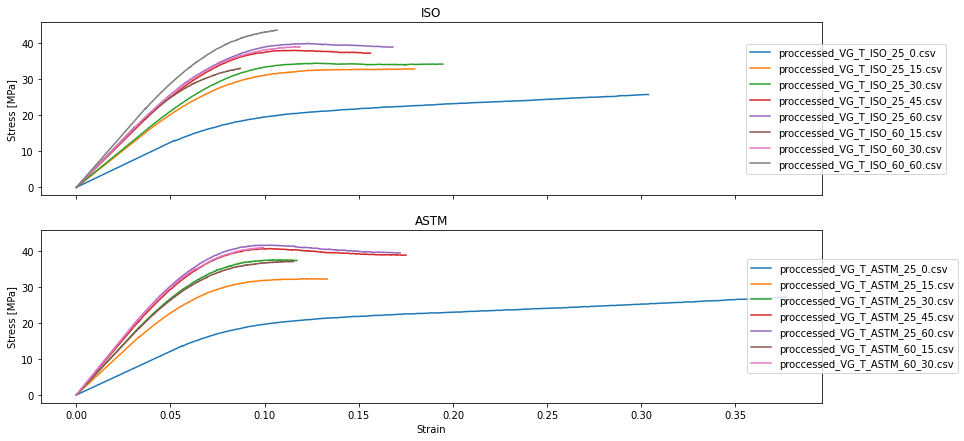

In [ ]:
fig, ax = plt.subplots(figsize=(14,7),nrows=2, ncols=1, sharex=True, sharey=True)
ax = ax.flatten()

i = 0
for label in sorted(list(proc_data)):
  if "ISO" in label:
    i = 0
  elif "ASTM" in label:
    i = 1
  ax[i].plot(proc_data[label]["STRAIN"].values,proc_data[label]["STRESS [MPa]"].values, label=label)
  
ax[0].set_title("ISO")
ax[1].set_title("ASTM")
ax[0].legend(loc='center right',bbox_to_anchor=(1.165,0.5))
ax[1].legend(loc='center right',bbox_to_anchor=(1.18,0.5))

ax[1].set_xlabel("Strain")
ax[0].set_ylabel("Stress [MPa]")
ax[1].set_ylabel("Stress [MPa]")

plt.show()

## Curing time effect: 
Plot samples at 25C at each curing time comparing both standards

Plot samples at 60C at each curing time comparing both standards

In [ ]:
label_tmp = label[11:-4]
label_tmp.split("_")[2]

'ISO'

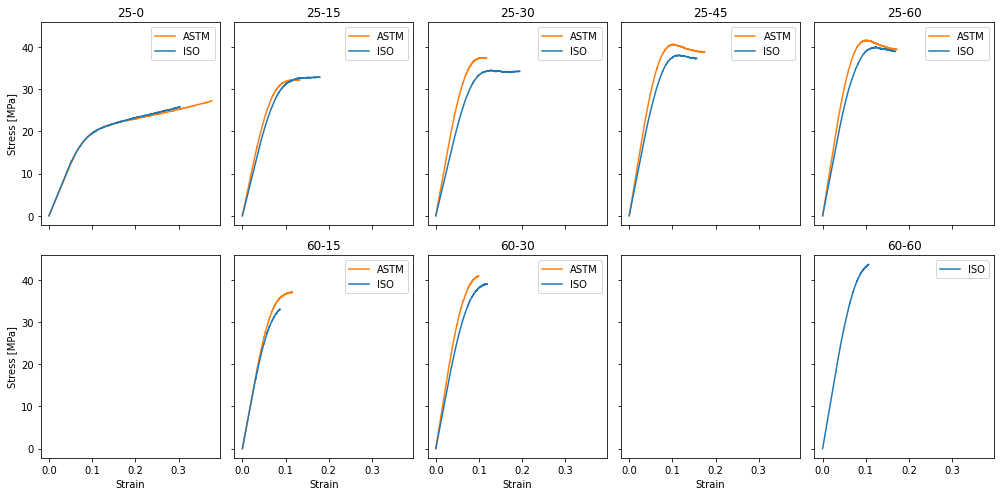

In [ ]:
fig, ax = plt.subplots(figsize=(14,7),nrows=2, ncols=5, sharex=True, sharey=True)
i = 0
for label in sorted(list(proc_data)):
  label_tmp = label[11:-4]
  if "25" == label_tmp.split("_")[3]:
    if "0" == label_tmp.split("_")[4]:
      i = 0
    elif "15" == label_tmp.split("_")[4]:
      i = 1
    elif "30" == label_tmp.split("_")[4]:
      i = 2
    elif "45" == label_tmp.split("_")[4]:
      i = 3
    elif "60" == label_tmp.split("_")[4]:
      i = 4
    if "ISO" == label_tmp.split("_")[2]:
      color = "C0"
    elif "ASTM" == label_tmp.split("_")[2]:
      color = "C1"
    ax[0,i].plot(proc_data[label]["STRAIN"].values,proc_data[label]["STRESS [MPa]"].values, color=color,label=label_tmp.split("_")[2])
    ax[0,i].set_title(label_tmp.split("_")[3] +"-"+label_tmp.split("_")[4])
    ax[0,i].legend()
    #ax[-3].set_xlabel("Strain")
    #ax[5].set_ylabel("Stress [MPa]")
    
  elif "60" == label_tmp.split("_")[3]:
    if "0" == label_tmp.split("_")[4]:
      i = 0
    elif "15" == label_tmp.split("_")[4]:
      i = 1
    elif "30" == label_tmp.split("_")[4]:
      i = 2
    elif "45" == label_tmp.split("_")[4]:
      i = 3
    elif "60" == label_tmp.split("_")[4]:
      i = 4
    if "ISO" == label_tmp.split("_")[2]:
      color = "C0"
    elif "ASTM" == label_tmp.split("_")[2]:
      color = "C1"
    ax[1,i].plot(proc_data[label]["STRAIN"].values,proc_data[label]["STRESS [MPa]"].values, color=color, label=label_tmp.split("_")[2])
    ax[1,i].set_title(label_tmp.split("_")[3] +"-"+label_tmp.split("_")[4])
    ax[1,i].legend()
for i in range(4):
  ax[1,i].set_xlabel("Strain")
    
ax[0,0].set_ylabel("Stress [MPa]")
ax[1,0].set_ylabel("Stress [MPa]")

plt.tight_layout()
plt.show()

## Curing temperature effect: 

Plot samples at equal curing time, both temperatures comparing both standards

In [ ]:
label_tmp

'VG_T_ISO_60_60'

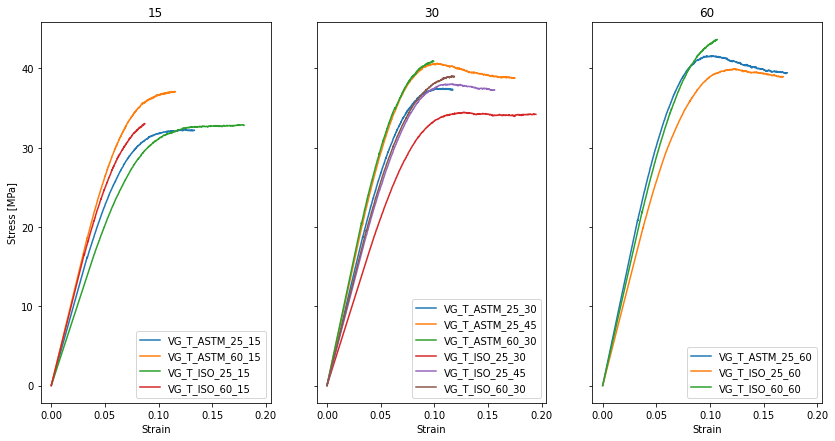

In [ ]:
fig, ax = plt.subplots(figsize=(14,7),nrows=1, ncols=3, sharex=True, sharey=True)
ax = ax.flatten()

for label in sorted(list(proc_data)):
  label_tmp = label[11:-4]
  if "0" == label_tmp.split("_")[4]:
    continue
  if "15" == label_tmp.split("_")[4]:
    i = 0
  elif "30" == label_tmp.split("_")[4]:
    i = 1
  elif "60" == label_tmp.split("_")[4]:
    i = 2
  ax[i].plot(proc_data[label]["STRAIN"].values,proc_data[label]["STRESS [MPa]"].values, label=label_tmp)
  ax[i].set_title(label)
  
ax[0].set_title("15")
ax[1].set_title("30")
ax[2].set_title("60")
ax[0].legend()
ax[1].legend()
ax[2].legend()

ax[0].set_xlabel("Strain")
ax[1].set_xlabel("Strain")
ax[2].set_xlabel("Strain")
ax[0].set_ylabel("Stress [MPa]")
plt.show()

# Clearing folders

In [ ]:
%rm -r data/*
%rm -r figures/*
%rm -r results/*

In [ ]:
!pwd

/content


In [ ]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? n
Nothing done.
